In [4]:
import os
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import librosa
from scipy.stats import skew, kurtosis, median_abs_deviation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 설정: 대상 동물과 데이터 경로 설정
target_animal = 'dog'  # 'cat', 'dog' 중 선택

# 경로 설정
main_path = os.path.join(os.getcwd().rsplit(
    'FurEmotion-AI')[0], 'FurEmotion-AI')
data_path = os.path.join(main_path, 'data', target_animal)

sys.path.append(main_path)

if not os.path.exists(data_path):
    raise ValueError(f'No such animal data path: {data_path}')

state_list = [dir_path for dir_path in os.listdir(
    data_path) if os.path.isdir(os.path.join(data_path, dir_path))]
print(f"분류할 상태 목록: {state_list}")  # ['relax', 'hostile', 'whining']

분류할 상태 목록: ['relax', 'hostile', 'whining']


In [ ]:
def get_mfcc(file_path,
             sampling_freq=16000,
             mfcc_coef=40,
             mfcc_coef_retain=25,
             mfcc_window_duration=0.0232):
    """
    오디오 파일에 대한 MFCC를 분석한 뒤 값을 반환한다.

    Parameters:
        file_path:            오디오 파일의 경로
        sampling_freq:        sampling rate
        mfcc_coef:            frame의 길이를 결정하는 파라미터.
        mfcc_coef_retain:     유지되는 MFCC 값의 길이
        mfcc_window_duration: 데이터를 읽을 때 겹쳐 읽는 길이(sec)

    Returns:
        list[0]: 초반 mfcc_coef_retain 만큼의 MFCC 값
        list[1]: 평균, 분산, 표준편차와 같은 MFCC의 특성값
    """

    # load wav file and normalize
    wave, sr = librosa.load(file_path, mono=True, sr=sampling_freq)
    wave = librosa.util.normalize(wave)

    # feature extraction
    mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=mfcc_coef, hop_length=int(
        mfcc_window_duration * sr / 2.0), n_fft=int(mfcc_window_duration * sr))

    # 정규화: 평균이 0, 표준편차 1
    mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)

    # keep the first mfcc_coef_retain coefficients
    mfccs = mfccs[:mfcc_coef_retain, :]

    # calculate MFCC statistics
    mfccs_min = mfccs.min(axis=1)
    mfccs_max = mfccs.max(axis=1)
    mfccs_median = np.median(mfccs, axis=1)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_var = np.var(mfccs, axis=1)
    mfccs_skewness = skew(mfccs, axis=1)
    mfccs_kurtosis = kurtosis(mfccs, axis=1)
    mfccs_mad = median_abs_deviation(mfccs, axis=1)

    mfccs_first_derivative = np.diff(mfccs, n=1, axis=1)
    mfccs_first_derivative_mean = np.mean(mfccs_first_derivative, axis=1)
    mfccs_first_derivative_var = np.var(mfccs_first_derivative, axis=1)

    mfccs_second_derivative = np.diff(mfccs, n=2, axis=1)
    mfccs_second_derivative_mean = np.mean(mfccs_second_derivative, axis=1)
    mfccs_second_derivative_var = np.var(mfccs_second_derivative, axis=1)

    mfccs_stats = np.vstack((mfccs_min, mfccs_max, mfccs_median, mfccs_mean, mfccs_var, mfccs_skewness, mfccs_kurtosis, mfccs_mad,
                            mfccs_first_derivative_mean, mfccs_first_derivative_var, mfccs_second_derivative_mean, mfccs_second_derivative_var))

    return pd.Series([mfccs, mfccs_stats.transpose()])


# Collect data and labels
data = []
labels = []

for idx, state in enumerate(state_list):
    state_path = os.path.join(data_path, state)
    for root, dirs, files in os.walk(state_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                mfccs, mfccs_stats = get_mfcc(file_path)
                mfccs = mfccs.transpose()  # shape: (num_frames, num_features)
                data.append(mfccs)
                labels.append(idx)

# Find the maximum sequence length
sequence_lengths = [mfcc.shape[0] for mfcc in data]
max_sequence_length = max(sequence_lengths)
print(f"Maximum sequence length: {max_sequence_length}")

num_samples = len(data)
num_features = data[0].shape[1]  # mfcc_coef_retain

# Initialize X
X = np.zeros((num_samples, max_sequence_length, num_features))

# Pad sequences
for i, mfcc in enumerate(data):
    sequence_length = mfcc.shape[0]
    X[i, :sequence_length, :] = mfcc

# Convert labels to categorical
num_classes = len(state_list)
y = tf.keras.utils.to_categorical(labels, num_classes)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

/var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/ipykernel_33002/3485007945.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  mfccs_skewness = skew(mfccs, axis=1)
/var/folders/10/9_p98m6j42n84y4wmf_k0krc0000gn/T/ipykernel_33002/3485007945.py:42: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  mfccs_kurtosis = kurtosis(mfccs, axis=1)


Maximum sequence length: 173


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# 모델 구성
model = tf.keras.Sequential([
    # 첫 번째 LSTM 레이어
    tf.keras.layers.LSTM(128, return_sequences=True,
                         input_shape=(max_sequence_length, num_features)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # 두 번째 LSTM 레이어
    tf.keras.layers.LSTM(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # 추가 Dense 레이어
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # 출력 레이어
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# 조기 종료 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',    # 모니터링할 지표
    patience=10,           # 개선이 없을 때 기다릴 에포크 수
    restore_best_weights=True  # 최상의 가중치 복원 여부
)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100,                # 충분한 에포크 수 설정
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # 조기 종료 콜백 추가
)

# 모델 저장
model.save(os.path.join(main_path, 'model', 'lstm_model.h5'))

Epoch 1/5
12/12 [==============================] - 2s 119ms/step - loss: 1.2258 - accuracy: 0.5493 - val_loss: 1.1203 - val_accuracy: 0.3723
Epoch 2/5
12/12 [==============================] - 1s 95ms/step - loss: 1.0603 - accuracy: 0.5627 - val_loss: 1.1023 - val_accuracy: 0.3830
Epoch 3/5
12/12 [==============================] - 1s 94ms/step - loss: 0.9754 - accuracy: 0.5787 - val_loss: 1.0824 - val_accuracy: 0.3936
Epoch 4/5
12/12 [==============================] - 1s 85ms/step - loss: 0.9713 - accuracy: 0.5787 - val_loss: 1.0589 - val_accuracy: 0.4043
Epoch 5/5
12/12 [==============================] - 1s 107ms/step - loss: 0.8715 - accuracy: 0.6373 - val_loss: 1.0448 - val_accuracy: 0.4255


/Users/jaewone/ENTER/envs/tf24/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 35ms/step - loss: 1.0448 - accuracy: 0.4255
Test Loss: 1.0448030233383179, Test Accuracy: 0.42553192377090454
3/3 [==============================] - 0s 30ms/step
[[ 5  1 28]
 [ 2  0 23]
 [ 0  0 35]]
              precision    recall  f1-score   support

       relax       0.71      0.15      0.24        34
     hostile       0.00      0.00      0.00        25
     whining       0.41      1.00      0.58        35

    accuracy                           0.43        94
   macro avg       0.37      0.38      0.27        94
weighted avg       0.41      0.43      0.30        94



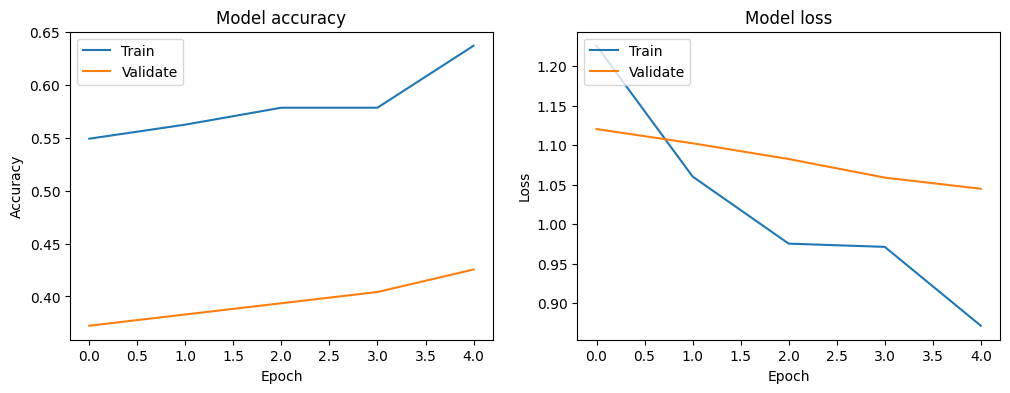

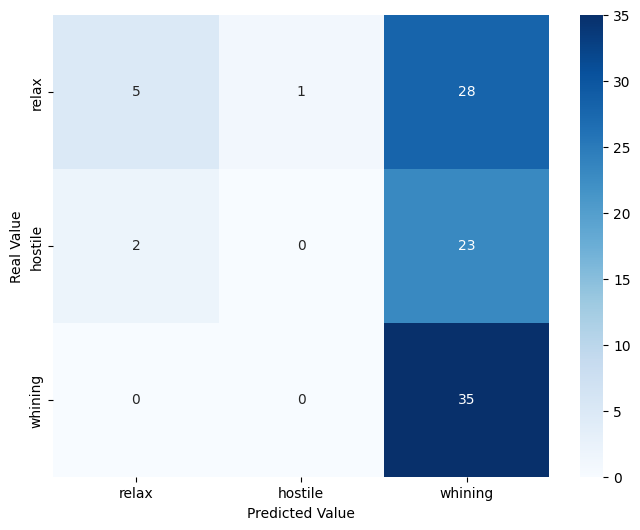

In [16]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predict and get confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

print(classification_report(y_true, y_pred_classes, target_names=state_list))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=state_list, yticklabels=state_list)
plt.ylabel('Real Value')
plt.xlabel('Predicted Value')
plt.show()